In [1]:
###############################################################################
# LICENSE
#Copyright (C) 2018 - INPE - NATIONAL INSTITUTE FOR SPACE RESEARCH
#This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
#This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
#You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.
###############################################################################
#======================================================================================================
# GNC-A Blog Python Tutorial: Derived Motion Winds
#======================================================================================================

# Required libraries ==================================================================================
import matplotlib.pyplot as plt                         # Import the Matplotlib package
# from mpl_toolkits.basemap import Basemap                # Import the Basemap toolkit
# import numpy as np                                      # Import the Numpy package
# from remap_g16 import remap                                 # Import the Remap function
from cpt_convert import loadCPT                         # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap   # Linear interpolation for color maps
import matplotlib.patheffects as path_effects
from datetime import datetime, timedelta                # Library to convert julian day to dd-mm-yyyy
from netCDF4 import Dataset                             # Import the NetCDF Python interface
import os                                # Miscellaneous operating system interfaces
import numpy as np                       # Import the Numpy package
import colorsys                          # To make convertion of colormaps
import matplotlib.colors as mcolors
import cartopy, cartopy.crs as ccrs  # Plot maps
import cartopy.feature as cfeature       # Import Cartopy features for borders and coastlines
from cartopy.io.shapereader import Reader
import boto3                             # Amazon Web Services (AWS) SDK for Python
from botocore import UNSIGNED            # boto3 config
from botocore.config import Config       # boto3 config
import math                              # Mathematical functions
#from datetime import datetime            # Basic Dates and time types
import datetime
from osgeo import osr                    # Python bindings for GDAL
from osgeo import gdal                   # Python bindings for GDAL
import time as t
import math                              # Import the Math package
from io import BytesIO
from PIL import Image

#======================================================================================================

In [2]:
############################################################
# LICENSE
# Copyright (C) 2018 - INPE - NATIONAL INSTITUTE FOR SPACE RESEARCH
# This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
# This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
# You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.
############################################################

# Define KM_PER_DEGREE
KM_PER_DEGREE = 111.32

# GOES-16 Spatial Reference System
sourcePrj = osr.SpatialReference()
#sourcePrj.ImportFromProj4('+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027489803406172 +lat_0=0.0 +lon_0=-75 +sweep=x +no_defs')
sourcePrj.ImportFromProj4('+proj=geos +h=35786000 +a=6378140 +b=6356750 +lon_0=-75 +sweep=x')

# Lat/lon WSG84 Spatial Reference System
targetPrj = osr.SpatialReference()
#targetPrj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
targetPrj.ImportFromProj4('+proj=latlong +datum=WGS84')

def exportImage(image,path):
    driver = gdal.GetDriverByName('netCDF')
    return driver.CreateCopy(path,image,0)

def getGeoT(extent, nlines, ncols):
    # Compute resolution based on data dimension
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]

def getScaleOffset(path, variable):
    nc = Dataset(path, mode='r')
    
    if (variable == "BCM") or (variable == "ACM") or (variable == "Phase") or (variable == "Smoke") or (variable == "Dust") or (variable == "Mask") or (variable == "Power"): 
        scale = 1
        offset = 0     
    else:
        scale = nc.variables[variable].scale_factor
        offset = nc.variables[variable].add_offset
    nc.close()
    return scale, offset
    
def remap(path, variable, extent, resolution, x1, y1, x2, y2):
    
    scale = 1
    offset = 0
    
    # GOES-16 Extent (satellite projection) [llx, lly, urx, ury]
    GOES16_EXTENT = [x1, y1, x2, y2]
    
    # Setup NetCDF driver
    gdal.SetConfigOption('GDAL_NETCDF_BOTTOMUP', 'NO')
        
    if not (variable == "DQF"):              
        # Read scale/offset from file
        scale, offset = getScaleOffset(path, variable) 
        #print(scale)
        #print(offset)
      
    connectionInfo = 'HDF5:\"' + path + '\"://' + variable
    
    raw = gdal.Open(connectionInfo)          
    
    # Setup projection and geo-transformation
    raw.SetProjection(sourcePrj.ExportToWkt())
    raw.SetGeoTransform(getGeoT(GOES16_EXTENT, raw.RasterYSize, raw.RasterXSize))  

    # Compute grid dimension
    sizex = int(((extent[2] - extent[0]) * KM_PER_DEGREE) / resolution)
    sizey = int(((extent[3] - extent[1]) * KM_PER_DEGREE) / resolution)
    
    # Get memory driver
    memDriver = gdal.GetDriverByName('MEM')
   
    # Create grid
    grid = memDriver.Create('grid', sizex, sizey, 1, gdal.GDT_Float32)
        
    # Setup projection and geo-transformation
    grid.SetProjection(targetPrj.ExportToWkt())
    grid.SetGeoTransform(getGeoT(extent, grid.RasterYSize, grid.RasterXSize))

    # Perform the projection/resampling 
    print ('Remapping...')#, path)
        
    start = t.time()
    
    gdal.ReprojectImage(raw, grid, sourcePrj.ExportToWkt(), targetPrj.ExportToWkt(), gdal.GRA_NearestNeighbour, options=['NUM_THREADS=ALL_CPUS']) 
    
    print ('Remap finished! Time:', t.time() - start, 'seconds')
               
    # Read grid data
    array = grid.ReadAsArray()
    
    # Mask fill values (i.e. invalid values)
    np.ma.masked_where(array, array == -1, False)
    
    array = array.astype(np.uint16)  
       
    # Apply scale and offset
    array = array * scale + offset

    # Get the raster 
    grid.GetRasterBand(1).WriteArray(array)

	# Close file
    raw = None
	
    return grid

d:\Downloads\Test_goes\GOES_env\Lib\site-packages\osgeo\osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [3]:
def download_CMI(yyyymmddhhmn, band, path_dest, product_name):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'
  #product_name = 'ABI-L2-CMIPF'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6C{int(band):02.0f}_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Band-{band}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

def get_info(path):
    #==================================================================================================
    # Getting Information From the File Name
    #==================================================================================================
    # Search for the Scan start in the file name
    Start = (path[path.find("_s")+2:path.find("_e")])
    # Converting from julian day to dd-mm-yyyy
    year = int(Start[0:4])
    dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y')  # Format the date according to the strftime directives
    time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
    # Date as string
    date_save = dayconventional.strftime('%Y%m%d')
    # Time (UTC) as string
    time_save = Start [7:9] + Start [9:11]

    #==================================================================================================
    # Detect the product type
    #==================================================================================================
    start_index = path.find("L2-") + 3
    end_index_m3 = path.find("-M3")
    end_index_m4 = path.find("-M4")
    end_index_m6 = path.find("-M6")
    # Choose the minimum index value that is not -1
    end_index = min(index for index in [end_index_m3, end_index_m4, end_index_m6] if index != -1)

    product = path[start_index:end_index]
    print(product)

    # CMIPF - Cloud and Moisture Imagery: 'CMI'
    if (product == "CMIPF") or (product == "CMIPC") or (product == "CMIPM"):
        variable = 'CMI'
        vmin = -50
        vmax = 50
        cmap = "jet"

    # ACHAF - Cloud Top Height: 'HT'
    elif product == "ACHAF":
        variable = 'HT'
        vmin = 0
        vmax = 15000
        cmap = "rainbow"

    # ACHTF - Cloud Top Temperature: 'TEMP'
    elif product == "ACHTF":
        variable = 'TEMP'
        vmin = 180
        vmax = 300
        cmap = "jet"

    # ACMF - Clear Sky Masks: 'BCM'
    elif product == "ACMF":
        variable = 'BCM'
        vmin = 0
        vmax = 1
        cmap = "gray"

    # ACTPF - Cloud Top Phase: 'Phase'
    elif product == "ACTPF":
        variable = 'Phase'
        vmin = 0
        vmax = 5
        cmap = "jet"

    # ADPF - Aerosol Detection: 'Smoke'
    elif product == "ADPF":
        variable = 'Smoke'
        vmin = 0
        vmax = 255
        cmap = "jet"

        #variable = 'Dust'
        #vmin = 0
        #vmax = 255
        #cmap = "jet"

    # AODF - Aerosol Optical Depth: 'AOD'
    elif product == "AODF":
        variable = 'AOD'
        vmin = 0
        vmax = 2
        cmap = "rainbow"

    # CODF - Cloud Optical Depth: 'COD'
    elif product == "CODF":
        variable = 'COD'
        vmin = 0
        vmax = 100
        cmap = "jet"

    # CPSF - Cloud Particle Size: 'PSD'
    elif product == "CPSF":
        variable = 'PSD'
        vmin = 0
        vmax = 80
        cmap = "rainbow"

    # CTPF - Cloud Top Pressure: 'PRES'
    elif product == "CTPF":
        variable = 'PRES'
        vmin = 0
        vmax = 1100
        cmap = "rainbow"

    # DMWF - Derived Motion Winds: 'pressure','temperature', 'wind_direction', 'wind_speed'
    elif product == "DMWF":
        variable = 'pressure'
        #variable = 'temperature'
        #variable = 'wind_direction'
        #variable = 'wind_speed'

    # DSIF - Derived Stability Indices: 'CAPE', 'KI', 'LI', 'SI', 'TT'
    elif product == "DSIF":
        variable = 'CAPE'
        vmin = 0
        vmax = 1000
        cmap = "jet"

        #variable = 'KI'
        #vmin = -50
        #vmax = 50
        #cmap = "jet"

        #variable = 'LI'
        #vmin = -10
        #vmax = 30
        #cmap = "jet"

        #variable = 'SI'
        #vmin = -10
        #vmax = 25
        #cmap = "jet"

        #variable = 'TT'
        #vmin = -10
        #vmax = 60
        #cmap = "jet"

    # DSRF - Downward Shortwave Radiation: 'DSR'
    #elif product == "DSRF":
        #    variable = 'DSR'

    # FDCF - Fire-Hot Spot Characterization: 'Area', 'Mask', 'Power', 'Temp'
    elif product == "FDCF":
        #variable = 'Area'

        variable = 'Mask'
        vmin = 0
        vmax = 255
        cmap = "jet"

        #variable = 'Power'
        #variable = 'Temp'

    # FSCF - Snow Cover: 'FSC'
    elif product == "FSCF":
        variable = 'FSC'
        vmin = 0
        vmax = 1
        cmap = "jet"

    # LSTF - Land Surface (Skin) Temperature: 'LST'
    elif product == "LSTF":
        variable = 'LST'
        vmin = 213
        vmax = 330
        cmap = "jet"

    # RRQPEF - Rainfall Rate - Quantitative Prediction Estimate: 'RRQPE'
    elif product == "RRQPEF":
        variable = 'RRQPE'
        vmin = 0
        vmax = 50
        cmap = "jet"

    # RSR - Reflected Shortwave Radiation: 'RSR'
    #elif product == "RSRF":
        #    variable = 'RSR'

    # SSTF - Sea Surface (Skin) Temperature: 'SST'
    elif product == "SSTF":
        variable = 'SST'
        vmin = 268
        vmax = 308
        cmap = "jet"

    # TPWF - Total Precipitable Water: 'TPW'
    elif product == "TPWF":
        variable = 'TPW'
        vmin = 0
        vmax = 60
        cmap = "jet"

    # VAAF - Volcanic Ash: 'VAH', 'VAML'
    elif product == "VAAF":
        #variable = 'VAH'
        #vmin = 0
        #vmax = 20000
        #cmap = "jet"

        variable = 'VAML'
        vmin = 0
        vmax = 100
        cmap = "jet"

    return product, variable, vmin, vmax, cmap, date_save, time_save

#======================================================================================================
# Remap the GOES-16 file (Returns the remapped Grid)
#======================================================================================================
def remap_g16(path, extent, resolution, variable):
    # Open the file using the NetCDF4 library
    nc = Dataset(path)

    # Get the latitude and longitude image bounds
    geo_extent = nc.variables['geospatial_lat_lon_extent']
    min_lon = float(geo_extent.geospatial_westbound_longitude)
    max_lon = float(geo_extent.geospatial_eastbound_longitude)
    min_lat = float(geo_extent.geospatial_southbound_latitude)
    max_lat = float(geo_extent.geospatial_northbound_latitude)

    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H

    # Close the NetCDF file after getting the data
    nc.close()

    # Call the reprojection funcion
    grid = remap(path, variable, extent, resolution, x1, y1, x2, y2)

    return grid

def plot_g16(data, extent, product, variable, date_save, time_save):

    if (variable == "Dust") or (variable == "Smoke") or (variable == "TPW") or (variable == "PRES") or  (variable == "HT") or \
    (variable == "TEMP") or (variable == "AOD") or (variable == "COD") or (variable == "PSD") or  (variable == "CAPE") or  (variable == "KI") or \
    (variable == "LI") or (variable == "SI") or (variable == "TT") or (variable == "FSC") or  (variable == "RRQPE") or (variable == "VAML") or (variable == "VAH"):
        data[data == max(data[0])] = np.nan
        data[data == min(data[0])] = np.nan

    if (variable == "SST"):
        data[data == max(data[0])] = np.nan
        data[data == min(data[0])] = np.nan

        # Call the reprojection funcion again to get only the valid SST pixels
        grid = remap(path, "DQF", extent, resolution, x1, y1, x2, y2)
        data_DQF = grid.ReadAsArray()
        # If the Quality Flag is not 0, set as NaN
        data[data_DQF != 0] = np.nan

    if (variable == "Mask"):
        data[data == -99] = np.nan
        data[data == 40] = np.nan
        data[data == 50] = np.nan
        data[data == 60] = np.nan
        data[data == 150] = np.nan
        data[data == max(data[0])] = np.nan
        data[data == min(data[0])] = np.nan

    if (variable == "BCM"):
        data[data == 255] = np.nan
        data[data == 0] = np.nan

    if (variable == "Phase"):
        data[data >= 5] = np.nan
        data[data == 0] = np.nan

    if (variable == "LST"):
        data[data >= 335] = np.nan
        data[data <= 200] = np.nan

    if (variable == "CMI"):
        #data[data == max(data[0])] = np.nan
        #data[data == min(data[0])] = np.nan

        # Getting information from the file name ==============================================================
        # Search for the GOES-16 channel in the file name
        index_m3c = path.find("M3C")
        index_m4c = path.find("M4C")
        index_m6c = path.find("M6C")

        # Choose the minimum index value that is not -1
        start_index = min(index for index in [index_m3c, index_m4c, index_m6c] if index != -1) + 3

        end_index = path.find("_G16")
        band = int(path[start_index:end_index])

        # Create a GOES-16 Bands string array
        Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
        # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
        if Band <= 6:
            Unit = "Reflectance"
            data = data
        else:
            Unit = "Brightness Temperature [°C]"
            # If it is an IR channel subtract 273.15 to convert to ° Celsius
            data = data - 273.15
            # Make pixels outside the footprint invisible
            data[data <= -180] = np.nan

    # Choose a title for the plot
    #Title = " GOES-16 ABI CMI Band " + str(Band) + "       " +  Wavelenghts[int(Band)] + "       " + Unit + "       " + date + "       " + time
    # Insert the institution name
    #Institution = "GNC-A Blog"

    #==================================================================================================
    # Plot the Data
    #==================================================================================================

    if (variable == "CMI"):
        if Band <= 6:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('Square Root Visible Enhancement.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=0, vmax=1)
            # Insert the colorbar at the bottom
        elif Band == 7:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('SVGAIR2_TEMP.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-112.15, vmax=56.85)
            # Insert the colorbar at the bottom
        elif Band > 7 and Band < 11:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('SVGAWVX_TEMP.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-112.15, vmax=56.85)
            # Insert the colorbar at the bottom
        elif Band > 10:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('IR4AVHRR6.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            #bmap.imshow(data, origin='upper', cmap='gray', vmin=-103, vmax=84)
            bmap.imshow(data, origin='upper', cmap='gray_r', vmin=-70, vmax=40)
            # Insert the colorbar at the bottom
    else:
        bmap.imshow(data, origin='upper', cmap=cmap, vmin=vmin, vmax=vmax)

    #cb = bmap.colorbar(location='bottom', size = '1%', pad = '-1.0%')
    #cb.outline.set_visible(False)                              # Remove the colorbar outline
    #cb.ax.tick_params(width = 0)                               # Remove the colorbar ticks
    #cb.ax.xaxis.set_tick_params(pad=-17)                     # Put the colobar labels inside the colorbar
    #cb.ax.tick_params(axis='x', colors='black', labelsize=12)  # Change the color and size of the colorbar labels

    # Save the result
    # plt.savefig('E:\\VLAB\\Python\\Output\\G16_' + product + '_' + variable + '_' + date_save + time_save + '.png', dpi=DPI, pad_inches=0)
    
def fig_to_image(im):

    buf = BytesIO()
    im.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf)
    return img



In [6]:
# Receives the date in UTC-5 (local time) and a path destination to save the nc files and the output image

def plot_dmw (path_dest, date):
    local_time = datetime.datetime.strptime(date, "%Y%m%d%H%M")
    utc_time = local_time - timedelta(hours=-5)
    yyyymmddhhmn = utc_time.strftime("%Y%m%d%H%M")

    Band = 14
    
    file1 = download_CMI(yyyymmddhhmn, Band, path_dest, 'ABI-L2-CMIPF')
    file2 = download_CMI(yyyymmddhhmn, 14, path_dest, 'ABI-L2-DMWF')

    if file1 is None:
         print('No CMI files for the selected datetime')
         return -1    
    if file2 is None:
         print('No DMW files for the selected datetime')
         return -1
    # Load the Data =======================================================================================
    # Path to the GOES-16 image file
    path = path_dest + file1 + '.nc'
    # Path to the GOES-16 derived motion winds and file reading:
    path_dmwf = path_dest + file2 + '.nc'

    product, variable, vmin, vmax, cmap, date_save, time_save = get_info(path)

    x_lat = 20
    x_lon = 20
    extent = [-73.722451-x_lon, 9.789103-x_lat, -73.722451+x_lon, 9.789103+x_lat]
    adjusted_extent = [extent[0], extent[2], extent[1], extent[3]]
    resolution = 2

    # Call the remap function
    grid = remap_g16(path, extent, resolution, variable)
    data_im = grid.ReadAsArray()
    data_im = data_im.astype(np.float64)

    # Define the size of the saved picture
    DPI = 150
    fig = plt.figure(figsize=(data_im.shape[1]/float(DPI), data_im.shape[0]/float(DPI)), frameon=False, dpi=DPI)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.axis('off')

    # # Read the required variables:
    # pressure = nc_xr['pressure'].values
    # temperature = nc_xr['temperature'].values
    # wind_direction = nc_xr['wind_direction'].values
    # wind_speed = nc_xr['wind_speed'].values
    # lats = nc_xr['lat'].values
    # lons = nc_xr['lon'].values

    # Opening the NetCDF
    nc = Dataset(path_dmwf)

    # Read the required variables: ================================================
    pressure = nc.variables['pressure'][:]
    temperature = nc.variables['temperature'][:]
    wind_direction = nc.variables['wind_direction'][:]
    wind_speed = nc.variables['wind_speed'][:]
    lats = nc.variables['lat'][:]
    lons = nc.variables['lon'][:]

    latli = np.argmin(np.abs(lats - extent[1]))  # Lower index
    latui = np.argmin(np.abs(lats - extent[3]))  # Upper index
    lon_ind = np.where((lons >= extent[0]) & (lons <= extent[2]))[0]
    lon_ind = lon_ind[(lon_ind >= latui) & (lon_ind <= latli)]

    # Convert lists to NumPy arrays
    pressure_a = np.array([pressure[item] for item in lon_ind])
    temperature_a = np.array([temperature[item] for item in lon_ind])
    wind_direction_a = np.array([wind_direction[item] for item in lon_ind])
    wind_speed_a = np.array([wind_speed[item] for item in lon_ind])
    lats_a = np.array([lats[item] for item in lon_ind])
    lons_a = np.array([lons[item] for item in lon_ind])

    # Define pressure ranges and colors
    pressure_ranges = [
        (100, 249, '#0000FF'),   # Blue
        (250, 399, '#309AFF'),   # Light Blue
        (400, 549, '#00FF00'),   # Green
        (550, 699, '#FFFF00'),   # Yellow
        (700, 849, '#FF0000'),   # Red
        (850, 1000, '#FF2FCD')   # Violet
    ]

    # Create Cartopy map
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(adjusted_extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE)

    # Loop through pressure ranges and plot wind barbs
    for pressure_min, pressure_max, color in pressure_ranges:
        pressure_index = np.where((pressure_a >= pressure_min) & (pressure_a <= pressure_max))[0]
        
        if len(pressure_index) > 0:
            lons_b = lons_a[pressure_index]
            lats_b = lats_a[pressure_index]
            wind_direction_b = wind_direction_a[pressure_index]
            wind_speed_b = wind_speed_a[pressure_index]
            
            u = -(np.asarray(wind_speed_b) * np.sin(np.deg2rad(wind_direction_b)))
            v = -(np.asarray(wind_speed_b) * np.cos(np.deg2rad(wind_direction_b)))

            # Plot wind barbs
            ax.barbs(lons_b, lats_b, u, v, length=7, pivot='middle', color=color, transform=ccrs.PlateCarree())

    # Shapefiles for provinces and countries
    # ax.add_geometries(Reader('content/Shapefiles/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp').geometries(), 
    #                   ccrs.PlateCarree(), edgecolor='yellow', facecolor='none', linewidth=0.1)
    # ax.add_geometries(Reader('content/Shapefiles/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp').geometries(), 
    #                   ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=1)

    # Plot the data

    if (variable == "CMI"):
            index_m3c = path.find("M3C")
            index_m4c = path.find("M4C")
            index_m6c = path.find("M6C")
            # Choose the minimum index value that is not -1
            start_index = min(index for index in [index_m3c, index_m4c, index_m6c] if index != -1) + 3
            end_index = path.find("_G16")
            band = int(path[start_index:end_index])

            # Create a GOES-16 Bands string array
            Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
            # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
            if Band <= 6:
                Unit = "Reflectance"
                data_im = data_im
            else:
                Unit = "Brightness Temperature [°C]"
                # If it is an IR channel subtract 273.15 to convert to ° Celsius
                data_im = data_im - 273.15
                # Make pixels outside the footprint invisible
                data_im[data_im <= -180] = np.nan

    cpt = loadCPT('IR4AVHRR6.cpt')
    cpt_convert = LinearSegmentedColormap('cpt', cpt)
    # bmap.imshow(data_im, origin='upper', cmap='gray_r', vmin=-70, vmax=40)
    img = ax.imshow(data_im, origin='upper', extent=adjusted_extent, cmap='gray_r', vmin=-70, vmax=40, transform=ccrs.PlateCarree())
    # img = ax.imshow(data_im, origin='upper', extent=adjusted_extent, cmap='gray', transform=ccrs.PlateCarree())

    # plot_g16(data_im, extent, product, variable, date_save, time_save)

    # Insert the legend
    plt.text(extent[0] + 0.5, extent[1] + 6.6, '249-100 hPa', fontsize=25, color='#0000FF').set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])
    plt.text(extent[0] + 0.5, extent[1] + 5.5, '399-250 hPa', fontsize=25, color='#309AFF').set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])
    plt.text(extent[0] + 0.5, extent[1] + 4.5, '400-549 hPa', fontsize=25, color='#00FF00').set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])
    plt.text(extent[0] + 0.5, extent[1] + 3.5, '699-550 hPa', fontsize=25, color='#FFFF00').set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])
    plt.text(extent[0] + 0.5, extent[1] + 2.5, '849-700 hPa', fontsize=25, color='#FF0000').set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])
    plt.text(extent[0] + 0.5, extent[1] + 1.5, '1000-850 hPa', fontsize=25, color='#FF2FCD').set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
])

    datetime_str = date_save + time_save
    utc_time = datetime.datetime.strptime(datetime_str, "%Y%m%d%H%M")
    local_time = utc_time - timedelta(hours=5)
    formatted_time = local_time.strftime("%B %d, %Y - %I:%M %p")
    plt.text(
        extent[0] + 0.5, extent[3] - 1, formatted_time,
        fontsize=25, color='white'
    ).set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),  
        path_effects.Normal()
    ])

    # Second title: original content without the date and time
    second_title = "CMI Band " + str(Band) + " " + Wavelenghts[int(Band)] + " " + Unit
    plt.text(
        extent[0] + 0.5, extent[1] + 0.5, second_title,
        fontsize=25, color='white'
    ).set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),  
        path_effects.Normal()
    ])
    # ax.add_geometries(Reader('content/Shapefiles/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp').geometries(), 
    #                   ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=3)


    ## Saving the final image
    output_folder = os.path.join(path_dest, 'DMW_images')
    os.makedirs(output_folder, exist_ok=True)
    # plt.savefig(f'{output_folder}/DMW_Band_{Band}_{date}.png', bbox_inches='tight', pad_inches=0, dpi=DPI)
    
    plt.show()
    # Delete the downloaded nc files
    nc.close()
    try:
        os.remove(path)
        os.remove(path+'.aux.xml')
        os.remove(path_dmwf)
    except OSError as e:
        print(f"Error: {e.filename} - {e.strerror}.")
    
    return fig


CMIPF
Remapping...
Remap finished! Time: 0.350177526473999 seconds


C:\Users\rodhe\AppData\Local\Temp\ipykernel_9304\1367837817.py:72: UserWarning: Warning: converting a masked element to nan.
  temperature_a = np.array([temperature[item] for item in lon_ind])


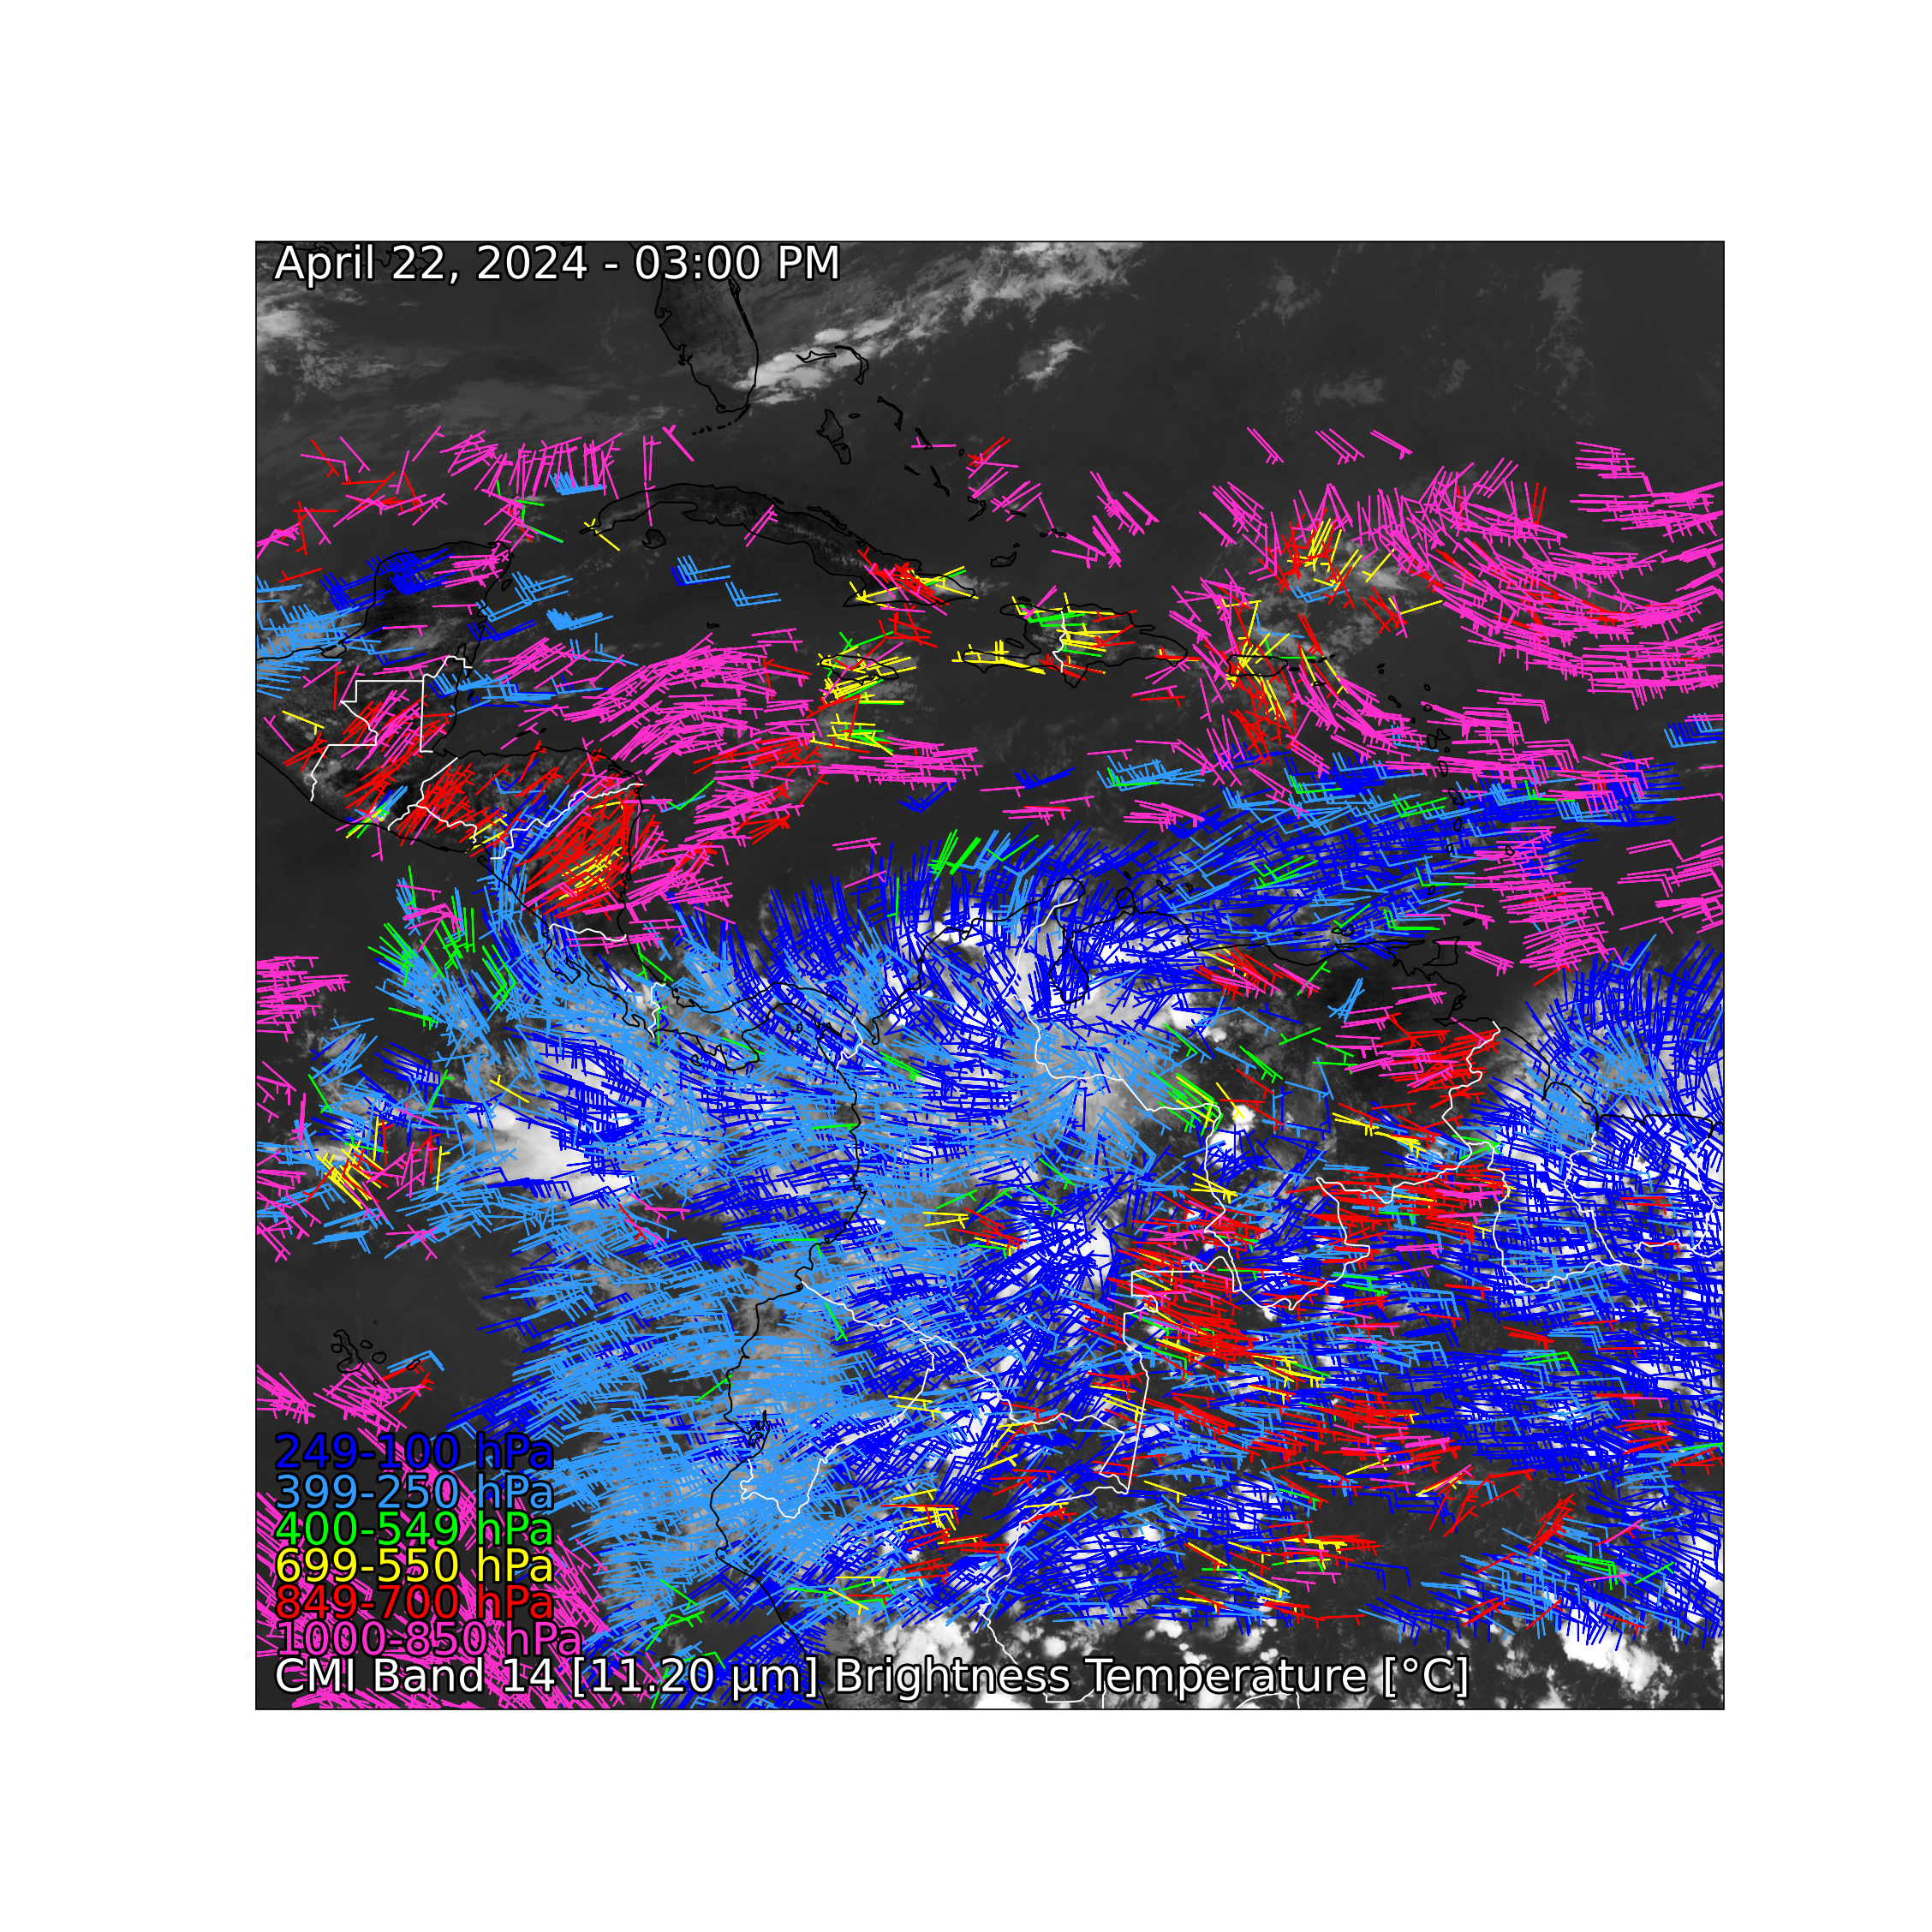

In [7]:
path_dest = 'content/Samples/'
date = "202404221500" # datetime formated as yyyymmddhhmm in UTC-5

im = plot_dmw (path_dest, date)
image = fig_to_image(im)
image.show()